# RL PRACTICE ➡️ Pig Dice Game | Pass the Pigs (`numba`version)

<div class="alert alert-info">
<h2>Objective</h2>
<p>Find and optimal policy for playing the game (in either of the possible variants: <code>GAME_PIG_DICE</code> or <code>GAME_PASS_THE_PIGS</code>)  using a RL Dynamic Programming algorithm</p>  
<p>You can choose either a <code>Policy Iteration & Improvement</code> algorithm or a<code>Value Iteration</code> algorithm</p>  
<p>Review the general documentation included in the assingment description for obtaining a general inutition of the mechanics of the game</p>  
<h2>Notes</h2>
<p>🟨 For guiding and helping you in understanding the types of <b>representations</b> (states, actions, policies) used and the <b>system dynamics</b> of the environment you are provided with some code for examples of policies [Policy helpers (opponent's policies)] and for the transitioning rules of the game [Basic simplified environment ➡️ As numba functions]</p>  
<p>🟨 You will not need such functions but, however, you might just need to include (copy) pieces of this code into your final algorithm for implementing the sweeps of state/action/state transitions in your algorithm</p>
<p>🟨 Additionally, you are provided with a basic example for the visualization of the resulting policies [Utility and plotting functions]. You may use those or either implement other specific tools/plots that you consider more convenient for the visualization, interpretation or explanation of the policies obtained</p>  
<p>🟨 The code is adapted for <code>numba</code> for faster execution, but in this case you can implement your algorithms practically with no change from standard python syntax. In the case, that you find difficulties or error that make the debugging process more complicated, just comment out the <code>@njit</code> decorators</p>
<hr>
<strong>
Review the notebook and fill in the missing code appropriately.<br>
Check the final executability and results of the resulting code.
</strong></div>

## Imports and variables

In [1]:
# ------------------------------------------------------------
# Two-player Pig (current-player view), Dynamic Programming (value iteration)
# and Q-learning via self-play. Compares vs "hold at 25" heuristic.
# Produces 3D policy plots for each policy.

# from __future__ import annotations
import math, random, time
from collections import defaultdict
import typing
from typing import Dict, Tuple, Literal

import numpy as np
import pickle

import numba
from numba import njit, typed, types # jit, prange, objmode
from numba import int32, float32    # import the basic types for numba specs
from numba.experimental import jitclass
# from numba.typed import Dict, List
"""
https://numba.readthedocs.io/en/stable/index.html
In @njit(nopython=True) functions, globals are treated as compile-time constants. 
You can read certain globals, but you generally cannot rebind them, and many Python containers are not supported.
⚠️ You may be able to mutate the contents of a global NumPy array inside @njit, but you cannot reassign the global name. 
It’s safer and clearer to pass arrays (or typed.Dict) as arguments (passed by reference)
"""
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib widget

# -----------------------------
# Global configuration
# -----------------------------
GAMMA = 0.99         # almost undiscounted episodic game
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
RNG = random.Random(SEED)  # reproducible; change/seed as you like

# ----------------------------
# Game configuration
# ----------------------------
GOAL = 100
ROLL, HOLD = 0, 1
ACTIONS = (ROLL, HOLD)

GAME_PIG_DICE      = 0
GAME_PASS_THE_PIGS = 1
GAME = GAME_PASS_THE_PIGS
GAME = GAME_PIG_DICE

if GAME == GAME_PIG_DICE:
    DIE_SIDES = 6
    PIG_OUT  = 1
    outcomes = tuple(range(1,DIE_SIDES+1))
    out_prob = tuple([1.0/DIE_SIDES]*DIE_SIDES)
elif GAME == GAME_PASS_THE_PIGS:
    # OUTS      = ('PIG_OUT','PIGGYBACK','OINKER')
    PIGGYBACK = -2
    OINKER    = -1
    PIG_OUT   = 0
    # abridged system dynamics
    outcomes = (PIGGYBACK, OINKER, PIG_OUT, 1, 5, 10, 15, 20, 25, 40, 60)
    out_prob = (0.001, 0.0386, 0.1922, 0.1922, 0.31, 0.1168, 0.0846, 0.0525, 0.0056, 0.0049, 0.0016)

# If True, a player wins immediately if their *running* score (score+turn_total) reaches GOAL during the turn (without needing to hold). 
# If False, they must hold to bank.
INSTANT_WIN_ON_ROLL = True    

# ----------------------------
# RL Definitions
# ----------------------------
State  = Tuple[int, int, int]  # (me, opp, turn) # always from the point of view of Player A (me)
Bucket = Tuple[int, int, int]  # (me, opp, turn)
Policy  = np.ndarray # Dict[Tuple[int,int,int], int or float] # the "float" case is just for being able of holding np.nan (for some better 3d plots)
QValues = np.ndarray # Dict[Tuple[int,int,int], list of floats]

BUCKET = 10 # Points (for grouping scores into buckets)
MAX_BUCKETS = GOAL//BUCKET

## Policy helpers (opponent's policies)

In [2]:
# policy_roller() can be built as policy_hold_at_(GOAL)    
# policy_random() can be built as policy_hold_at_(randomize=True)    
def policy_hold_at_(threshold=25, randomize=False) -> np.ndarray: # Dict[State, Action]
    """Heuristic policy: hold if turn >= 25; always hold if can immediately win."""
    # P: Dict[State, int] = {}
    P = np.ones((GOAL,GOAL,GOAL),dtype=float)*HOLD # *np.nan # default is HOLD
    for me in range(GOAL):
        for opp in range(GOAL):
            max_turn = GOAL - 1 - me
            for turn in range(max_turn + 1):
                if me + turn >= GOAL:
                    P[(me, opp, turn)] = HOLD
                else:
                    if randomize:
                        P[(me, opp, turn)] = HOLD if turn >= random.randint(0,GOAL) else ROLL
                        # or alternatively...
                        # P[(me, opp, turn)] = HOLD if random.random() >= 0.5 else ROLL 
                    else:
                        P[(me, opp, turn)] = HOLD if turn >= threshold else ROLL
    return P

## Basic simplified environment ➡️ As `numba` functions

In [3]:
# -----------------------------
# Environment (current-player view)
# -----------------------------
@njit(fastmath=True)
def choice_weighted_idx(prob):
    # prob: 1D array of non-negative weights (need not sum to 1)
    L = len(prob)
    total = 0.0
    for i in range(L): total += prob[i]
    u = np.random.random() * total
    c = 0.0
    for i in range(L):
        c += prob[i]
        if u < c: return i
    return L - 1  # guard for rounding
    
@njit(fastmath=True)
def reset() -> Tuple[State, typing.Dict[str,int]]:
    return (0, 0, 0), {}

@njit(fastmath=True)
def step_1(s: State, a: int) -> Tuple[State, int, bool, bool, typing.Dict[str,int]]:
    """
    One environment step from state s using action a.
    Returns (next_state, reward, terminated, truncated, info) --> truncated means swap turns

    Reward is from the perspective of the *actor* at s:
    +1 if the actor wins, -1 if the actor loses, else 0.
    """
    me, opp, turn = s

    # Terminal guard (shouldn't be called on terminal states)
    if me >= GOAL:
        print('ERROR! Attempting a terminal state')   
        return s, +1, True, False, {'swap':0}
    if opp >= GOAL:
        print('ERROR! Attempting a terminal state')   
        return s, -1, True, False, {'swap':0}

    if a == HOLD:
        # Bank turn; if enough to win -> terminal +1
        if me + turn >= GOAL:
            return (me + turn, opp, 0), +1, True, False, {'swap':0}
        # Otherwise pass turn: roles swap => next current player is the (previous) opponent
        return (opp, me + turn, 0), 0, False, True, {'swap':1}
    
    # +-------------------------------------+
    # |         System Dynamics             |
    # +-------------------------------------+
    # a == "roll"
    if GAME == GAME_PIG_DICE:
        # d = random.randint(1, DIE_SIDES)
        # d = np.random.choice(outcomes, 1, p=out_prob)[0]
        # d = random.choices(outcomes, weights=out_prob, k=1)[0]
        d = outcomes[choice_weighted_idx(out_prob)]
        if d == PIG_OUT:
            # Pig out: lose running total, pass turn (roles swap)
            return (opp, me, 0), 0, False, True, {'swap':1}
        if me + turn + d >= GOAL:
            return (me + turn + d, opp, 0), +1, True, False, {'swap':0}
        return (me, opp, turn + d), 0, False, False, {'swap':0}
    elif GAME == GAME_PASS_THE_PIGS:    
        # abridged system dynamics
        # outcomes = [PIGGYBACK, OINKER, PIG_OUT, 1, 5, 10, 15, 20, 25, 40, 60]
        # out_prob = [0.001, 0.0386, 0.1922, 0.1922, 0.31, 0.1168, 0.0846, 0.0525, 0.0056, 0.0049, 0.0016]
        # d = np.random.choice(outcomes, 1, p=out_prob)[0]    
        d = outcomes[choice_weighted_idx(out_prob)]
        if d == PIGGYBACK: # Player is eliminated  (roles swap)
            return (opp, 0, 0), -1, True, False, {'swap':0}
        elif d == OINKER: # (Back to Zero) Player's total score from the game is wiped out
            return (opp, 0, 0), 0, False, True, {'swap':1}
        elif d == PIG_OUT: # Pigs lie on opposite sides --> Player's score for the turn is wiped out
            # Pig out: lose running total, pass turn (roles swap)
            return (opp, me, 0), 0, False, True, {'swap':1}
        elif me + turn + d >= GOAL:
            return (me + turn + d, opp, 0), +1, True, False, {'swap':0}
        else:
            return (me, opp, turn + d), 0, False, False, {'swap':0}
    print('ERROR! Undefined step return')   
    return (0, 0, 0), 0, False, False, {'swap':0}

# example...
step_1((0,1,2), HOLD)            

((1, 2, 0), 0, False, True, DictType[unicode_type,int64]<iv=None>({swap: 1}))

## Utility and plotting functions

In [4]:
def policy_to_array_expanded(policy,goal=GOAL):
    """Expands a "bucketed" policy and "clears" unreachable states"""
    if policy.shape[0] == goal:
        policy_arr = policy.astype(float)
    else:
        bucket_size, remainder = divmod(goal, policy.shape[0])
        if remainder != 0:
            raise Exception(f"{policy.shape[0]} not exactly expandable to {goal}")
        else:
            policy_arr = policy.repeat(bucket_size, axis=0).repeat(bucket_size, axis=1).repeat(bucket_size, axis=2).astype(float)
            # Alternative one-liner with np.kron:
            # policy_arr = np.kron(policy, np.ones((bucket_size, bucket_size, bucket_size), dtype=policy.dtype))
    for me in range(goal):
        for opp in range(goal):
            max_turn = goal - 1 - me
            for turn in range(goal):
                if me + turn >= goal:
                    policy_arr[me,opp,turn] = np.nan
    return policy_arr

def policy_to_array_compressed(policy,bucket_size=10):
    """Compress a policy into a "bucketed" policy"""
    buckets = GOAL//bucket_size
    # A = np.random.randn(15, 15, 15)  # your array
    # Average each 3×3×3 block → (5,5,5)
    B_float = policy.reshape(buckets, bucket_size, 
                        buckets, bucket_size, 
                        buckets, bucket_size).mean(axis=(1, 3, 5))
    
    # Convert averages to integers (round-to-nearest)
    B = np.rint(B_float).astype(int)
    return B


# --- Compute threshold surface t*(a,b): minimal t where HOLD is optimal
def threshold_surface(policy):
    policy_no_nan = np.nan_to_num(policy, nan=HOLD)
    thr = np.zeros((GOAL, GOAL), dtype=np.int32)
    for a in range(GOAL):
        for b in range(GOAL):
            hold_ts = np.where(policy_no_nan[a, b, :] == HOLD)[0]
            thr[a, b] = hold_ts[0] if hold_ts.size > 0 else GOAL - 1
    return thr

def plot_surface(thr, name):
    # --- 3D plot (waterfall/wireframe style) ---
    fig = plt.figure(figsize=(8, 6), facecolor="white")
    ax = fig.add_subplot(111, projection="3d")
    
    # Axes ranges
    ax.set_xlim(0, GOAL - 1)
    ax.set_ylim(0, GOAL - 1)
    ax.set_zlim(0, GOAL - 1)
    
    # Labels
    ax.set_xlabel("player score a")
    ax.set_ylabel("opponent score b")
    ax.set_zlabel("minimal t* to HOLD")
    
    # View
    ax.view_init(elev=28, azim=-55)
    
    # Style the panes/grid to be light
    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        axis._axinfo["grid"]['color'] = (0.7, 0.7, 0.7, 0.8)
    ax.xaxis.pane.set_facecolor((1, 1, 1, 0.0))
    ax.yaxis.pane.set_facecolor((1, 1, 1, 0.0))
    ax.zaxis.pane.set_facecolor((1, 1, 1, 0.0))
    
    # Waterfall lines for each opponent score b (colored by b)
    # import matplotlib.cm as cm
    # cmap = cm.get_cmap("viridis")
    # The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. 
    # Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
    cmap = plt.get_cmap("viridis")
    # cmap = mpl.colormaps.get_cmap('viridis') # Use the 'viridis' colormap
    cmap.set_bad(color='red') # Set NaN values to red
    
    a = np.arange(GOAL)
    for b in range(GOAL):
        z = thr[a, b]
        color = cmap(b / (GOAL - 1))
        ax.plot(a, np.full_like(a, b), z, color=color, linewidth=1.0, alpha=0.95)
    """
    # Overlay the "bank-to-win" surface t_win(a) = GOAL - a
    # Draw it as many vertical curtains (one per b) to resemble a slanted plane.
    twin = (GOAL - 1) - a  # stays within zlim (0..GOAL-1)
    for b in range(0, GOAL, 2):
        ax.plot(a, np.full_like(a, b), twin, color=cmap(1.0), linewidth=1.2, alpha=0.6)
    """
    plt.tight_layout()
    if name:
        out_path = f"data/threshold_surface_3d_{name}.png"
        plt.savefig(out_path, dpi=140, transparent=True)
        print(f"Saved 3D plot to: {out_path}")
    plt.show()


def save_array(arr,filename="file_no_name"):
    # Save the array to a file using Pickle
    with open(filename+'.pkl', 'wb') as file:
        pickle.dump(arr, file)
    return arr  

def load_array(filename):
    # Load the array back from the file
    with open(filename+'.pkl', 'rb') as file:
        arr = pickle.load(file)
    return arr

In [5]:
import os
# os.makedirs with exist_ok=True will not raise an error if the folder exists
os.makedirs('data', exist_ok=True)

## Heuristic policies Policy Visualization

Saved 3D plot to: data/threshold_surface_3d_hold_at_25.png


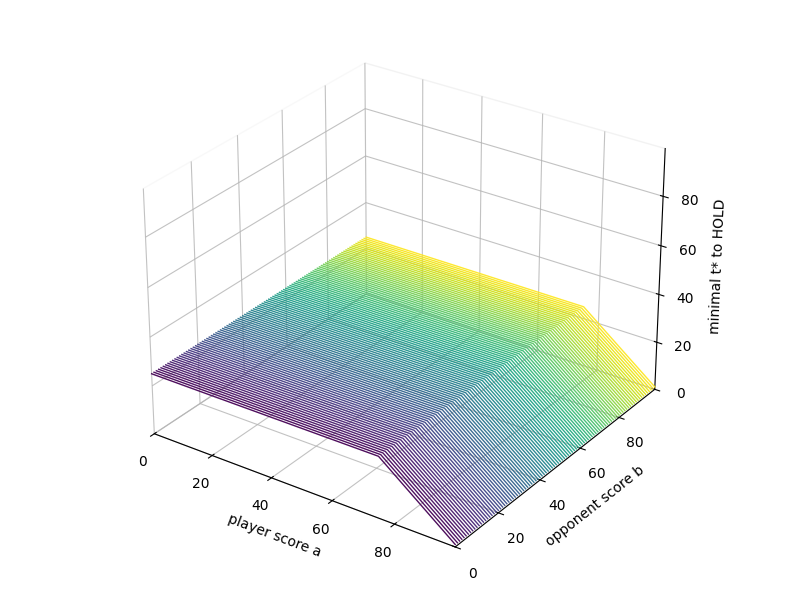

In [6]:
if True:
    policy_h25 = policy_hold_at_(25)
    
    policy_h25_a = policy_to_array_expanded(policy_h25)
    thr = threshold_surface(policy_h25_a)
    plot_surface(thr,'hold_at_25')    

# Assignment

## Dynamic Programming
**Choose and implement one algorithm**
* Policy Iteration and Improvement
* Value Iteration

In [7]:
# @jit(nopython=True)
# @njit  # or: @njit(inline='always')
@njit(parallel=True, fastmath=True)
def value_iteration(theta: float = 1e-9, max_iters: int = 2_000, verbose: bool = True):
    """
    Value iteration in current-player view
    Returns: (V, policy) where V is a defaultdict(float), policy is Dict[State, Action].
    Note: For GOAL=100, this is exact but may take some time to converge.
    """
    # Allocate values & policy
    V = np.zeros((GOAL, GOAL, GOAL), dtype=np.float64)
    policy = np.zeros((GOAL, GOAL, GOAL), dtype=np.uint8)
    
    ➡️ CONTINUE THE CODING...

    return V, policy

@njit(parallel=True, fastmath=True)
def policy_iteration(theta: float = 1e-9, max_iters: int = 2_000, verbose: bool = True):
    """
    Policy Iteration and Improvement in current-player view
    Returns: (V, policy) where V is a defaultdict(float), policy is Dict[State, Action].
    Note: For GOAL=100, this is exact but may take some time to converge.
    """
    # Allocate values & policy
    V = np.zeros((GOAL, GOAL, GOAL), dtype=np.float64)
    policy = np.zeros((GOAL, GOAL, GOAL), dtype=np.uint8)
    
    ➡️ CONTINUE THE CODING...

    return V, policy    

## Dynamic Programming (Value Iteration)

=== Dynamic Programming (Value Iteration) ===
[VI] iter 0   delta= 0.8333333333333333
[VI] iter 10   delta= 0.04662647306095835
[VI] iter 20   delta= 0.024505389287819423
[VI] iter 30   delta= 0.019536407599734573
[VI] iter 40   delta= 0.01560677075427419
[VI] iter 50   delta= 0.012090278927030296
[VI] iter 60   delta= 0.00881382292852223
[VI] iter 70   delta= 0.0055079217983752815
[VI] iter 80   delta= 0.003025069372471656
[VI] iter 90   delta= 0.0014900566738918486
[VI] iter 100   delta= 0.000697484546294258
[VI] iter 110   delta= 0.00031387135208871264
[VI] iter 120   delta= 0.00014420128426351209
[VI] iter 130   delta= 6.651846042360354e-05
[VI] iter 140   delta= 3.081297250845383e-05
[VI] iter 150   delta= 1.434911304681874e-05
[VI] iter 160   delta= 6.75190131710357e-06
[VI] iter 170   delta= 3.2186424715474615e-06
[VI] iter 180   delta= 1.564709552093202e-06
[VI] converged at iter 188   (delta= 9.65389686857776e-07 )
time: 1.861208200454712
Saved 3D plot to: data/threshold_surfa

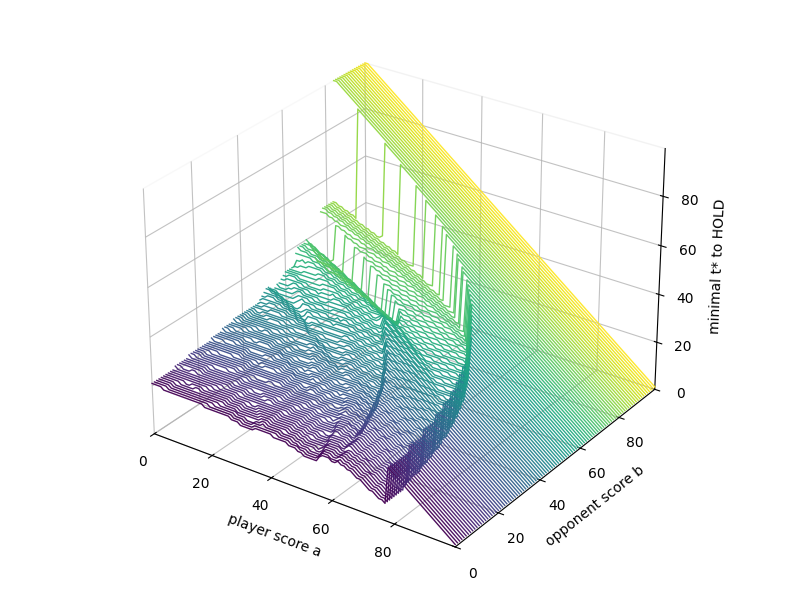

In [8]:
if True: # execute only when desired...
    THETA = 1e-6
    print("=== Dynamic Programming (Value Iteration) ===")
    _start = time.time()
    ➡️ V_dp, policy_dp = value_iteration(theta=THETA, max_iters=1_200, verbose=True)
    ➡️ or...
    ➡️ V_dp, policy_dp = policy_iteration(theta=THETA, max_iters=1_200, verbose=True)
    print('time:',time.time()-_start)

    save_array(V_dp, filename=f"data/values_dyn_prog_game-{GAME}")
    save_array(policy_dp, filename=f"data/policy_dyn_prog_game-{GAME}")
    
    policy_dp_a = policy_to_array_expanded(policy_dp)
    thr = threshold_surface(policy_dp_a)
    plot_surface(thr,f'dyn_prog_game-{GAME}')